### Implementar validación cruzada y explicar la elección de métricas de evaluación.

Predecir el IMC de una persona en función de sus hábitos, condiciones y estilo de vida.

In [19]:
features = [
    "bebealcohol",
    "actifisica",
    "tact_fisica",
    "horas_sueno",
    "duracion_siesta",
    "tiempo_beber",
    "multiples_diagnosticos"
]
# Seleccionados de acuerdo al heatmap en 02_visualizations.ipynb (> 0.3)


In [20]:
target = "signos_vitales_imc"

In [21]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

In [22]:
df = pd.read_csv("../data/processed/health_clean_data.csv")

In [23]:
df_model = df[features + [target]].dropna()
X = df_model[features]
y = df_model[target]
X

,bebealcohol,actifisica,tact_fisica,horas_sueno,duracion_siesta,tiempo_beber,multiples_diagnosticos
0,0.0,1.0,5.0,5.0,0.232075,7.0,1
1,1.0,1.0,7.0,7.0,0.044093,21.0,1
2,1.0,1.0,9.0,5.0,0.254118,28.0,1
3,1.0,1.0,5.0,2.0,0.110440,6.0,1
4,0.0,0.0,0.0,1.0,0.066456,10.0,0
...,...,...,...,...,...,...,...
273,0.0,1.0,5.0,5.0,0.229613,11.0,1
274,1.0,0.0,18.0,9.0,0.573895,28.0,1
275,1.0,1.0,25.0,9.0,0.774489,42.0,1
276,0.0,1.0,5.0,2.0,0.293799,4.0,1


In [24]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

cv = KFold(n_splits=5, shuffle=True, random_state=42)

mae = -cross_val_score(pipeline, X, y, cv=cv, scoring='neg_mean_absolute_error')
rmse = np.sqrt(-cross_val_score(pipeline, X, y, cv=cv, scoring='neg_mean_squared_error'))
r2 = cross_val_score(pipeline, X, y, cv=cv, scoring='r2')

#### Métricas:

- MAE (Mean Absolute Error): Es fácilmente interpretable. Indica el error promedio entre las predicciones del modelo y los valores reales de IMC, expresado en las mismas unidades.
- RMSE (Root Mean Squared Error): Métrica adicional, ya que penaliza de forma más severa los errores grandes, lo cual es útil cuando se desea minimizar predicciones excesivamente alejadas del valor real.
- R^2 (coeficiente de determinación): Evalua la capacidad explicativa global del modelo, es decir, qué proporción de la variabilidad total del IMC es capturada por las variables independientes.

In [25]:
mae_scores = -cross_val_score(pipeline, X, y, cv=cv, scoring="neg_mean_absolute_error")
rmse_scores = -cross_val_score(pipeline, X, y, cv=cv, scoring="neg_mean_squared_error")
r2_scores = cross_val_score(pipeline, X, y, cv=cv, scoring="r2")

print(f"MAE: {mae_scores.mean():.2f} ± {mae_scores.std():.2f}")
print(f"RMSE: {np.sqrt(rmse_scores).mean():.2f} ± {np.sqrt(rmse_scores).std():.2f}")
print(f"R²: {r2_scores.mean():.2f} ± {r2_scores.std():.2f}")

MAE: 6.12 ± 0.65
RMSE: 7.43 ± 0.81
R²: 0.63 ± 0.06


Modelo evaluado mediante validación cruzada con 5 particiones (K-Fold), utilizando métricas estándar de regresión:

El error absoluto medio (MAE) fue de 6.12 ± 0.65, lo que indica que, en promedio, el modelo se equivoca por aproximadamente 6 puntos de IMC.

El RMSE fue de 7.43 ± 0.81, lo cual sugiere que hay errores individuales más altos (el RMSE penaliza errores grandes más que el MAE).

El R² fue de 0.63 ± 0.06, lo que significa que el modelo logra explicar alrededor del 63% de la variabilidad en el IMC a partir de los factores seleccionados.

Aunque el error absoluto es relativamente alto, el valor de R² indica que el modelo logra capturar una buena parte del comportamiento del IMC, especialmente considerando que se usaron únicamente factores de estilo de vida (sin incluir datos clínicos más complejos)

### Segmentación

In [33]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns


In [28]:
df_cluster = df[features].dropna()
X = df_cluster.copy()

In [29]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

In [31]:
df_cluster["cluster"] = clusters

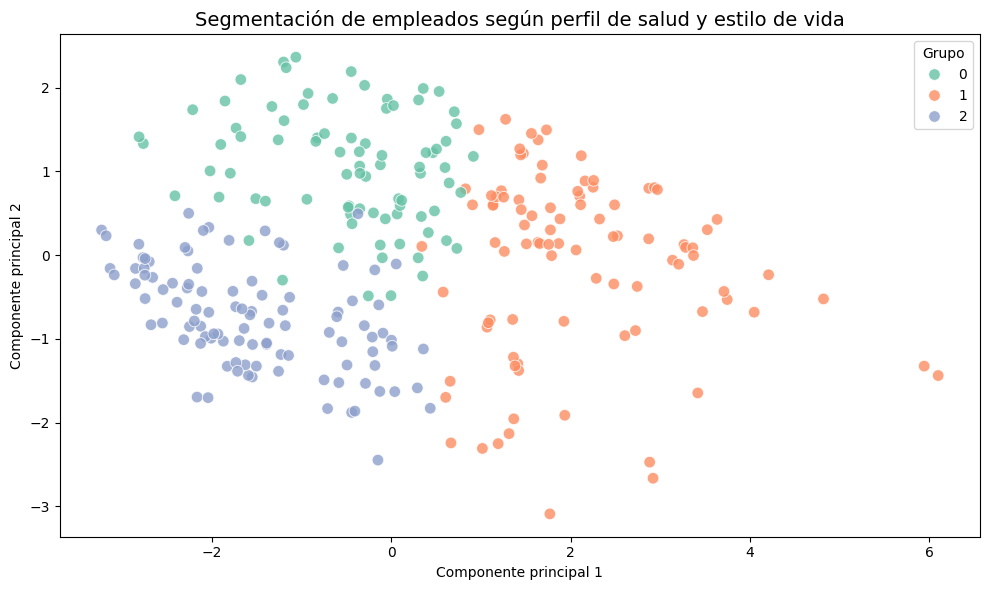

In [34]:

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_cluster["pca_1"] = X_pca[:, 0]
df_cluster["pca_2"] = X_pca[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_cluster,
    x="pca_1", y="pca_2",
    hue="cluster",
    palette="Set2",
    alpha=0.8,
    s=70
)
plt.title("Segmentación de empleados según perfil de salud y estilo de vida", fontsize=14)
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.legend(title="Grupo")
plt.tight_layout()
plt.show()


In [36]:
resumen_clusters = df_cluster.groupby("cluster")[
    features + ["pca_1", "pca_2"]
].mean().round(2)

tamanos_clusters = df_cluster["cluster"].value_counts().sort_index()

print("Distribución de variables por cluster:")
display(resumen_clusters)

print("\nTamaño de cada cluster:")
print(tamanos_clusters)


Distribución de variables por cluster:


,signos_vitales_imc,actifisica,horas_sueno,duracion_siesta,tact_fisica,tiempo_beber,tiempo_abstinencia_alcohol,pca_1,pca_2
cluster,,,,,,,,,
0,21.52,1.00,2.60,0.18,6.08,6.60,0.71,-0.48,1.05
1,28.94,0.77,6.88,0.33,13.18,20.01,1.18,2.09,-0.11
2,10.08,0.00,2.66,0.16,3.80,7.79,0.74,-1.52,-0.75



Tamaño de cada cluster:
cluster
0     83
1     93
2    102
Name: count, dtype: int64
